This notebook runs analyses on the forecasts created in the previous notebook. 

In [1]:
import pandas as pd
import glob
import os
import datetime
# import pvlib
from pv_model import model_pv_power
from forecast_solar import get_solar_forecast_fast
import matplotlib.pyplot as plt
# import scipy
import numpy as np

Read in specs that were processed and aggregated in the last notebook

In [2]:
folder = 'output_specs' 
filename = 'agg_specs_orig_df.pkl'
file_to_read = os.path.join(folder, filename)
agg_specs_orig_df = pd.read_pickle(file_to_read)
agg_specs_orig_df.head()

0            1            2            3            4   \
latitude        32.811041    31.719983    33.021601       31.888       31.255   
longitude       -99.91749  -104.442292    -99.61463     -100.825     -102.272   
nameplate_dc     131.5944   256.362179    94.507156   130.434783        234.0   
nameplate_ac        100.8        188.2         74.9        100.0        180.0   
mount_type    single-axis  single-axis  single-axis  single-axis  single-axis   

                       5            6            7            8            9   \
latitude        33.404486      30.4214    28.883196    31.435932    31.030996   
longitude      -96.082472     -97.4614   -99.178605   -99.796613  -102.488209   
nameplate_dc   170.854369        186.0        176.0        319.0   172.362353   
nameplate_ac        125.7        144.0        132.4        250.0        126.3   
mount_type    single-axis  single-axis  single-axis  single-axis  single-axis   

                       10           11           12           13           14  \
latitude        32.104125    33.467803      32.4744    32.460054    32.533273   
longitude     -100.162375   -95.370856     -95.7156  -102.672809   -96.428985   
nameplate_dc       143.08        260.0    82.098305      133.931   182.009816   
nameplate_ac        102.2        198.5         59.8        100.7        147.6   
mount_type    single-axis  single-axis  single-axis  single-axis  single-axis   

                       15           16           17           18           19  
latitude        34.380532    26.090103    33.261505    29.271667    29.242304  
longitude     -100.099625   -97.798453   -97.238057   -98.444722   -95.658144  
nameplate_dc   165.306333   184.861111   191.275636    53.936118        162.4  
nameplate_ac        121.4        137.5        148.8         39.2        120.0  
mount_type    single-axis  single-axis  single-axis  single-axis  single-axis

In [3]:
num_plants = len(agg_specs_orig_df)
num_plants

20

Get a list of the timeseries files:

In [4]:
# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*_actual_power_20240310-20250316.csv'))

Loop through plants and read in timeseries data:

In [5]:
agg_hsl = {}
agg_tel_net_out = {}

for plant_number in range(num_plants):
    # read in timeseries data from ERCOT
    ts_file = filelist_ts[plant_number]
    df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
    
    # outputs
    agg_hsl[plant_number] = df_ts['hsl']
    agg_tel_net_out[plant_number] = df_ts['telemetered_net_output']

# make dataframes 
agg_hsl_df = pd.concat(agg_hsl, axis=1)
agg_tel_net_out_df = pd.concat(agg_tel_net_out, axis=1)

Preview the data:

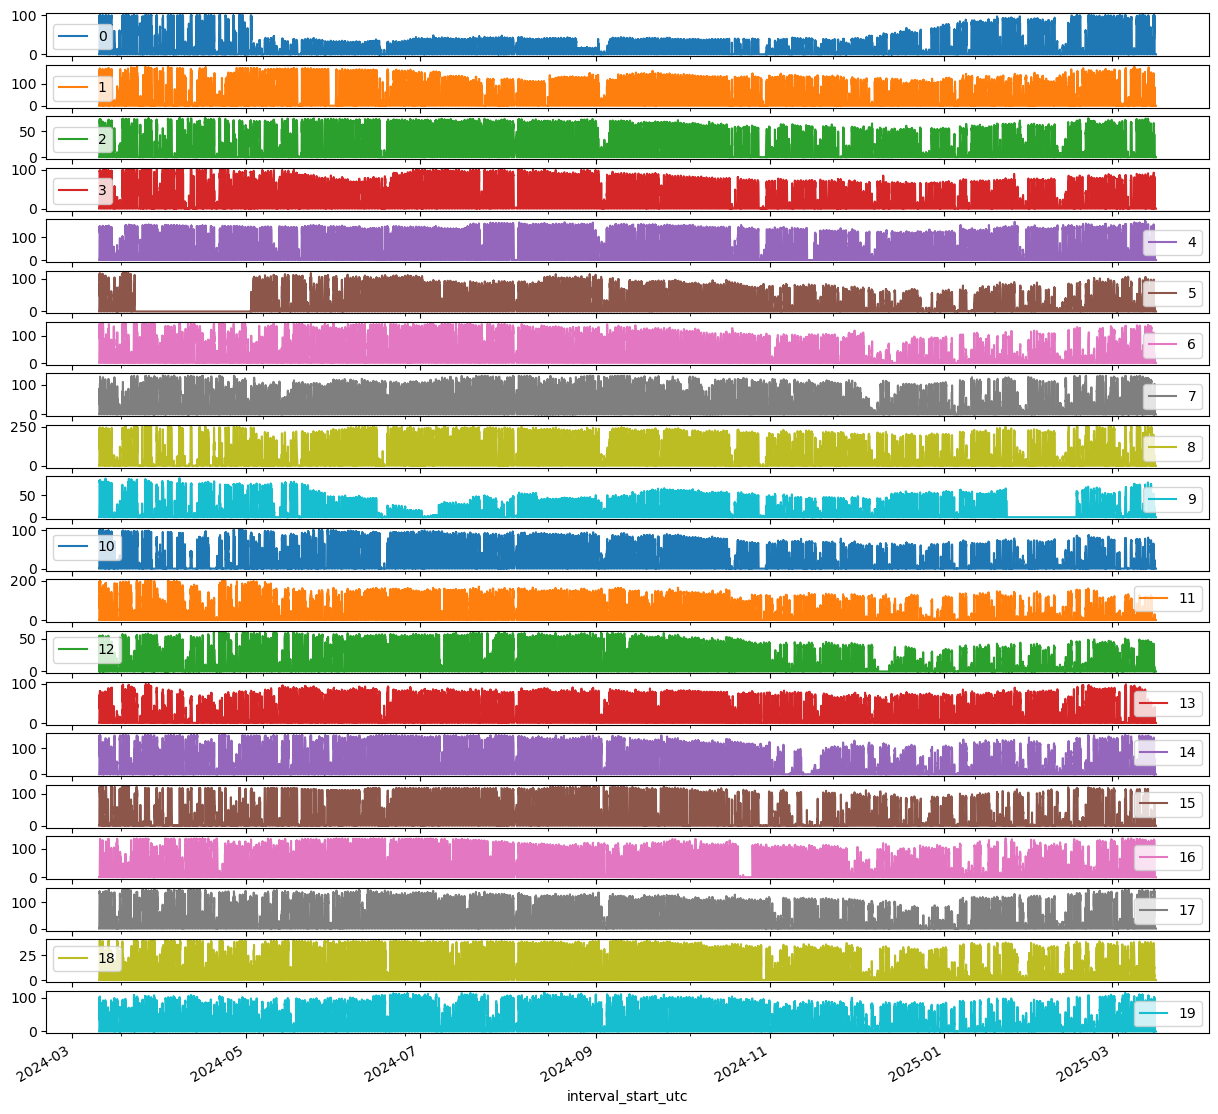

In [6]:
agg_tel_net_out_df.plot(subplots=True,figsize=(15,15))
plt.show()

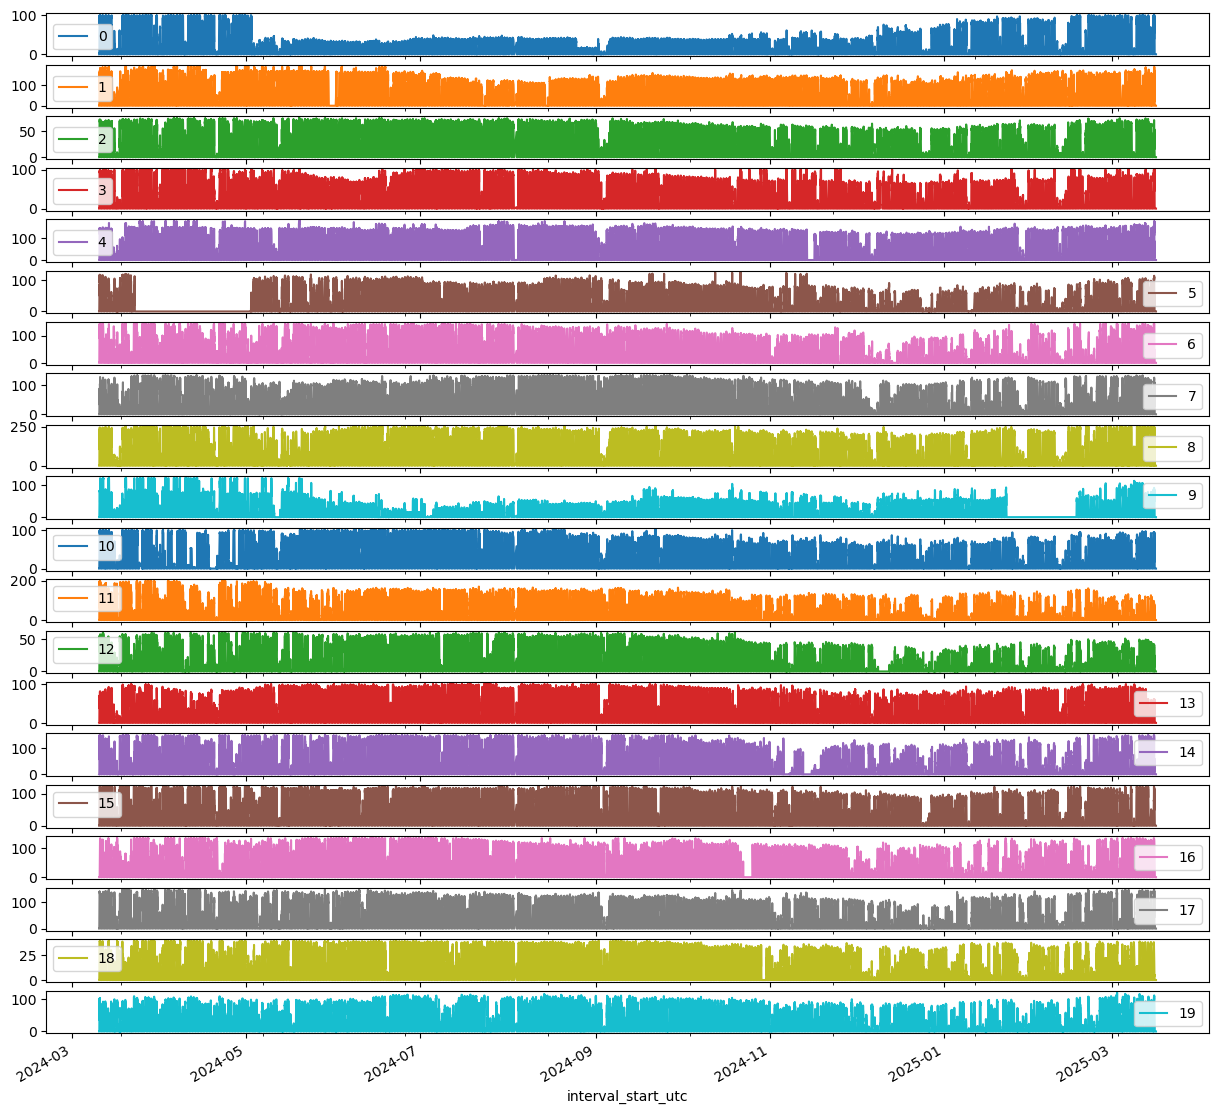

In [7]:
agg_hsl_df.plot(subplots=True,figsize=(15,15))
plt.show()

Plants 0, 5, and 9 look problematic, so we will skip those later. 

Filter and clean up observed power:
- select numerical columns of interest (`telemetered_net_output` and `hsl`)
- resample to hourly
- add curtailment flag
- make a new dataframe that is just uncurtailed power for each plant, where each column represents a plant. 
  - Uses `nan` for curtailed intervals and later ignore intervals where power is `nan`

In [8]:
thresh = 0.02 # fraction of peak power to set the curtailment threshold at
power_obs = agg_tel_net_out_df.resample('1h').mean()
hsl = agg_hsl_df.resample('1h').mean()
power_max_obs = power_obs.max()
curtailment = hsl - power_obs
curtailment_filter = curtailment > (thresh * power_max_obs)
# curtailment.iloc[:,0].plot()

# TODO: explore curtailment more:
- maybe add `base_point` and `hdl` later
- look at fraction of energy
  - maybe by month

Sample check of curtailment filter. We will use `fill_between` to shade areas with curtailment. But because `fill_between` needs two values to fill between, it won't work with single hours of curtailment (and it will trim one hour off of longer curtailments). So, we need to add an extra `True` value after any existing `True` in out curtailment filter timeseries. 

*Note: this means that single uncurtailed hours will now show up as curtailed in the plot below. This issue only applies to plotting here, not to filtering later...*

Based on https://stackoverflow.com/a/61437138/27574852. 



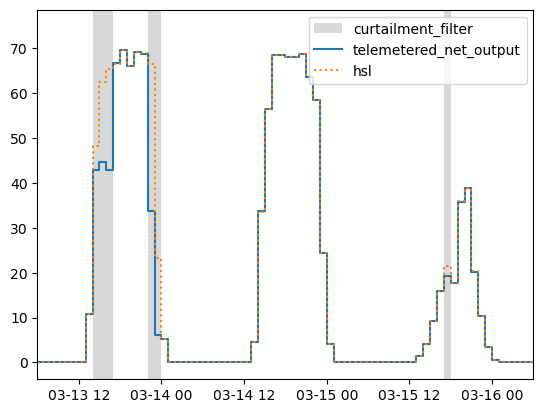

In [9]:
i=2
x = power_obs[i].index
y = power_obs[i]
y2 = hsl[i]
y3 = curtailment[i]
mask = curtailment_filter[i]
# add one extra True after each True
mask = mask.where(mask).ffill(limit=1).fillna(0).astype(bool)

fig, ax = plt.subplots()

ax.fill_between(x, 0, 1, where=mask, alpha=0.3,
                transform=ax.get_xaxis_transform(),
                label='curtailment_filter', facecolor='gray')

plt.plot(x, y, drawstyle='steps-post', label='telemetered_net_output')
plt.plot(x, y2, drawstyle='steps-post', label='hsl', linestyle=':')
# plt.plot(x, y3, drawstyle='steps-post', label='curtailment')
plt.xlim([pd.to_datetime('2024-03-13 6:00'), pd.to_datetime('2024-03-16 6:00')])

plt.legend()
plt.show()

Looks good enough. Let's apply the filter to the `power_obs` dataframe.

In [10]:
power_obs[curtailment_filter] = np.nan

And check with a plot:

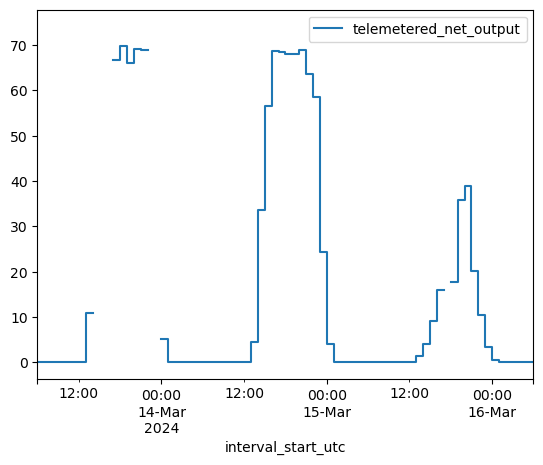

In [11]:
power_obs[i].plot(drawstyle='steps-post', label='telemetered_net_output')
plt.xlim([pd.to_datetime('2024-03-13 6:00'), pd.to_datetime('2024-03-16 6:00')])
plt.legend()
plt.show()

Let's import our forecasted power data:

In [12]:
power_fcasts_gfs_all = pd.read_csv('forecasts/power_fcasts_gfs_all.csv', parse_dates=['valid_time'], index_col='valid_time')
power_fcasts_ifs_all = pd.read_csv('forecasts/power_fcasts_ifs_all.csv', parse_dates=['valid_time'], index_col='valid_time')

In [13]:
power_fcasts_gfs_all.head()

power  point
valid_time                                 
2024-03-11 12:30:00+00:00   0.000000      0
2024-03-11 13:30:00+00:00  11.681972      0
2024-03-11 14:30:00+00:00  78.137555      0
2024-03-11 15:30:00+00:00  95.591996      0
2024-03-11 16:30:00+00:00  97.085507      0

Now, let's pull out the forecasted power data for each plant and then merge that with observed power.

*Note: our forecasts end on `2025-03-10`, a Monday, and we need it to end on a Sunday, so we will trim the dataframe.*

In [14]:
last_day = '2025-03-10'

power_fcasts_gfs = {}
power_fcasts_ifs = {}
power_obs_and_fcast = {}

for plant_number in range(num_plants):
    # pull plant data
    plant_data = agg_specs_orig_df[plant_number].to_dict()

    # get the power forecast for the plant
    power_fcasts_gfs = power_fcasts_gfs_all[power_fcasts_gfs_all['point']==plant_number]
    power_fcasts_ifs = power_fcasts_ifs_all[power_fcasts_ifs_all['point']==plant_number]

    # drop point column
    power_fcasts_gfs = power_fcasts_gfs.drop(columns=['point'])
    power_fcasts_ifs = power_fcasts_ifs.drop(columns=['point'])

    # adjust timestamps to beginning of interval to match observations
    power_fcasts_gfs.index = power_fcasts_gfs.index - pd.Timedelta('30min')
    power_fcasts_ifs.index = power_fcasts_ifs.index - pd.Timedelta('30min')

    # merge
    power_obs_and_fcast[plant_number] = pd.concat([power_obs[plant_number], power_fcasts_gfs, power_fcasts_ifs], axis=1, join='inner')

    # rename columns
    power_obs_and_fcast[plant_number].columns = ['power_obs', 'power_fcast_gfs', 'power_fcast_ifs']

    # make an averaged fcast
    power_obs_and_fcast[plant_number]['power_fcast_mean'] = (power_obs_and_fcast[plant_number]['power_fcast_gfs'] + power_obs_and_fcast[plant_number]['power_fcast_ifs']) / 2

    # trim to end before 2025-03-10
    power_obs_and_fcast[plant_number] = power_obs_and_fcast[plant_number][power_obs_and_fcast[plant_number].index < last_day]

A test plot:

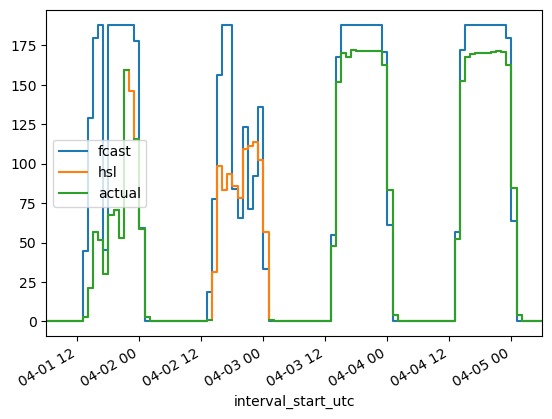

In [15]:
i=1
power_obs_and_fcast[i]['power_fcast_gfs'].plot(drawstyle='steps-post', label='fcast')
hsl[i].plot(drawstyle='steps-post', label='hsl')
power_obs_and_fcast[i]['power_obs'].plot(drawstyle='steps-post', label='actual')

plt.xlim([pd.to_datetime('2024-04-1 6:00'), pd.to_datetime('2024-04-5 6:00')])
plt.legend()
plt.show()

Now, we need to exclude intervals where there is curtailment (which should have `NaN` for observed power), so set the forecasts to `NaN` as well:

In [16]:
for i in range(num_plants):
    power_obs_and_fcast[i][power_obs_and_fcast[i]['power_obs'].isna()] = pd.NA

Check that same plot again:

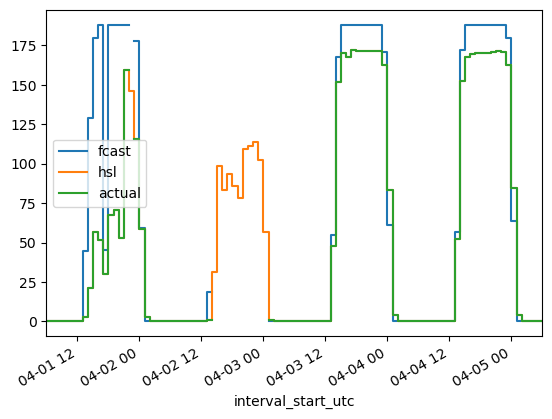

In [17]:
i=1
power_obs_and_fcast[i]['power_fcast_gfs'].plot(drawstyle='steps-post', label='fcast')
hsl[i].plot(drawstyle='steps-post', label='hsl')
power_obs_and_fcast[i]['power_obs'].plot(drawstyle='steps-post', label='actual')

plt.xlim([pd.to_datetime('2024-04-1 6:00'), pd.to_datetime('2024-04-5 6:00')])
plt.legend()
plt.show()

We see forecasts are null when observed power is null. That's good. 

Alternative option: simply use HSL as the observed power. 

If we replace intervals of curtailed power with `nan` for both observations and forecasts (as done above), curtailed days will have lower actual *and* forecasted power, making the forecasts potentially look better than they really are. 

This should be avoided, so for now, let's use HSL as observed power. 

In [18]:
power_obs = agg_hsl_df.resample('1h').mean()

In [19]:
last_day = '2025-03-10'

power_fcasts_gfs = {}
power_fcasts_ifs = {}
power_obs_and_fcast = {}

for plant_number in range(num_plants):
    # pull plant data
    plant_data = agg_specs_orig_df[plant_number].to_dict()

    # get the power forecast for the plant
    power_fcasts_gfs = power_fcasts_gfs_all[power_fcasts_gfs_all['point']==plant_number]
    power_fcasts_ifs = power_fcasts_ifs_all[power_fcasts_ifs_all['point']==plant_number]

    # drop point column
    power_fcasts_gfs = power_fcasts_gfs.drop(columns=['point'])
    power_fcasts_ifs = power_fcasts_ifs.drop(columns=['point'])

    # adjust timestamps to beginning of interval to match observations
    power_fcasts_gfs.index = power_fcasts_gfs.index - pd.Timedelta('30min')
    power_fcasts_ifs.index = power_fcasts_ifs.index - pd.Timedelta('30min')

    # merge
    power_obs_and_fcast[plant_number] = pd.concat([power_obs[plant_number], power_fcasts_gfs, power_fcasts_ifs], axis=1, join='inner')

    # rename columns
    power_obs_and_fcast[plant_number].columns = ['power_obs', 'power_fcast_gfs', 'power_fcast_ifs']

    # make an averaged fcast
    power_obs_and_fcast[plant_number]['power_fcast_mean'] = (power_obs_and_fcast[plant_number]['power_fcast_gfs'] + power_obs_and_fcast[plant_number]['power_fcast_ifs']) / 2

    # trim to end before 2025-03-10
    power_obs_and_fcast[plant_number] = power_obs_and_fcast[plant_number][power_obs_and_fcast[plant_number].index < last_day]

Sample plot:

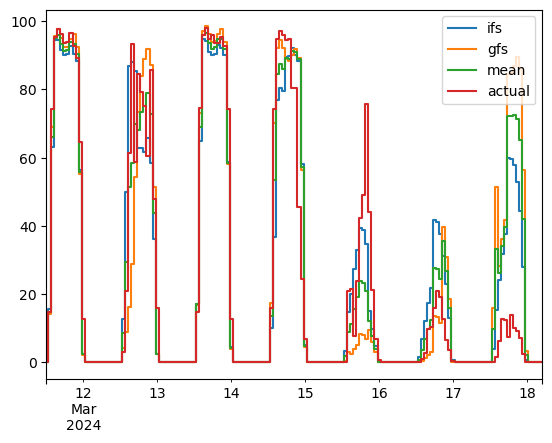

In [20]:
plant_number = 3

startidx=0
endidx=162

power_obs_and_fcast[plant_number]['power_fcast_ifs'][startidx:endidx].plot(drawstyle='steps-mid', label = 'ifs')
power_obs_and_fcast[plant_number]['power_fcast_gfs'][startidx:endidx].plot(drawstyle='steps-mid', label = 'gfs')
power_obs_and_fcast[plant_number]['power_fcast_mean'][startidx:endidx].plot(drawstyle='steps-mid', label = 'mean')
power_obs_and_fcast[plant_number]['power_obs'][startidx:endidx].plot(drawstyle='steps-mid', label = 'actual')
plt.legend()
plt.show()

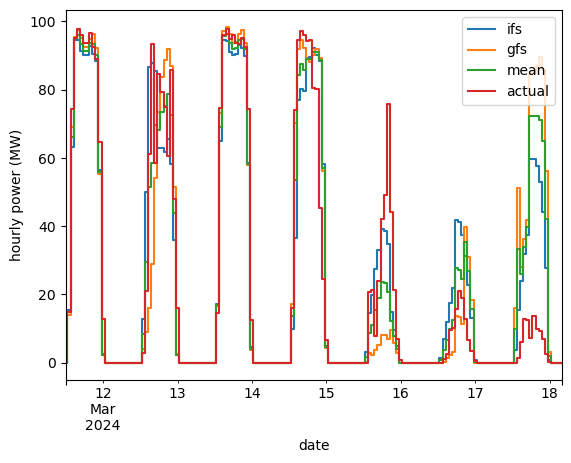

In [21]:
plant_number = 3
# start = pd.Timestamp('2024-04-23 0:00').tz_localize('US/Central')
df_plot = power_obs_and_fcast[plant_number].copy()
start = pd.Timestamp('2024-03-11 0:00').tz_localize('US/Central')
end = start + pd.Timedelta('7D')
mask = (df_plot.index >=start) & (df_plot.index <end)
df_plot['power_fcast_ifs'][mask].plot(drawstyle='steps-mid', label = 'ifs')
df_plot['power_fcast_gfs'][mask].plot(drawstyle='steps-mid', label = 'gfs')
df_plot['power_fcast_mean'][mask].plot(drawstyle='steps-mid', label = 'mean')
df_plot['power_obs'][mask].plot(drawstyle='steps-mid', label = 'actual')
plt.ylabel('hourly power (MW)')
plt.xlabel('date')
# plt.gcf().autofmt_xdate()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23), ncol=2)
plt.legend()
plt.savefig('images/sample_hourly_power.png', dpi=400, bbox_inches='tight')
plt.show()
 


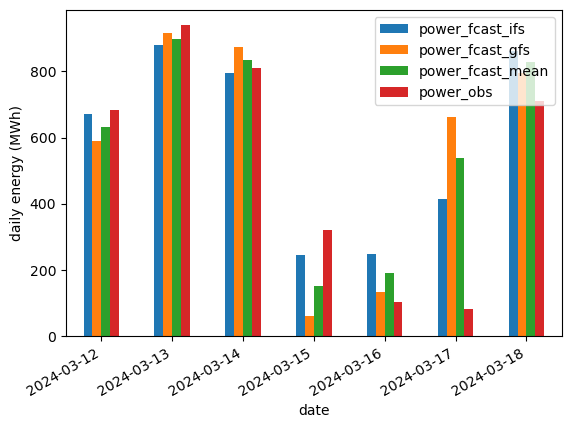

In [22]:
df_plot_daily = df_plot = power_obs_and_fcast[plant_number].copy().resample('1d').sum()
mask_daily = (df_plot_daily.index >=start) & (df_plot_daily.index <end)

df_plot_daily[['power_fcast_ifs', 'power_fcast_gfs', 'power_fcast_mean', 'power_obs']][mask_daily].plot(kind='bar')
labels = df_plot_daily[mask_daily].index.strftime('%Y-%m-%d')
plt.gca().set_xticklabels(labels)
plt.xlabel('date')
plt.ylabel('daily energy (MWh)')
plt.gcf().autofmt_xdate()
plt.savefig('images/sample_daily_energy_bar.png', dpi=400, bbox_inches='tight')
plt.show()

Now, some scatter plots:

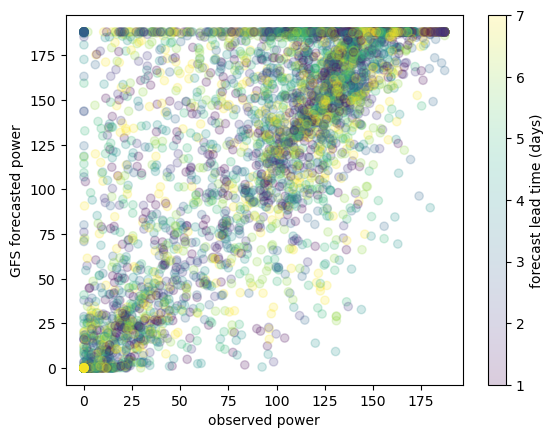

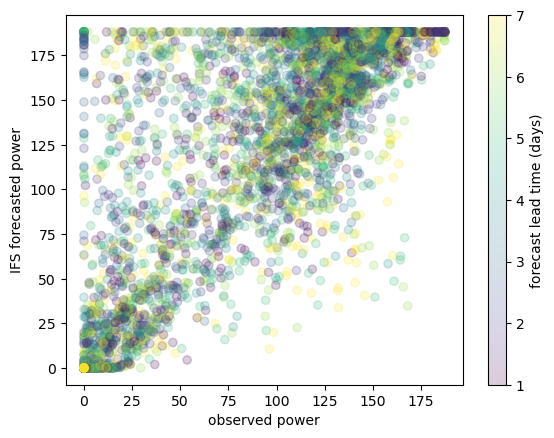

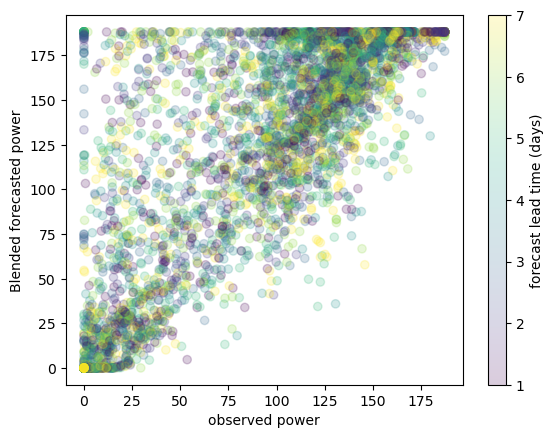

In [23]:
plt.scatter(power_obs_and_fcast[i]['power_obs'],
            power_obs_and_fcast[i]['power_fcast_gfs'],
            alpha=0.2,
            c=power_obs_and_fcast[i].index.dayofweek+1)
plt.colorbar(label='forecast lead time (days)')
plt.xlabel('observed power')
plt.ylabel('GFS forecasted power')
plt.show()

plt.scatter(power_obs_and_fcast[i]['power_obs'],
            power_obs_and_fcast[i]['power_fcast_ifs'],
            alpha=0.2,
            c=power_obs_and_fcast[i].index.dayofweek+1)
plt.colorbar(label='forecast lead time (days)')
plt.xlabel('observed power')
plt.ylabel('IFS forecasted power')
plt.show()

plt.scatter(power_obs_and_fcast[i]['power_obs'],
            power_obs_and_fcast[i]['power_fcast_mean'],
            alpha=0.2,
            c=power_obs_and_fcast[i].index.dayofweek+1)
plt.colorbar(label='forecast lead time (days)')
plt.xlabel('observed power')
plt.ylabel('Blended forecasted power')
plt.show()

Now, let's look at scatter plots of all the plants:

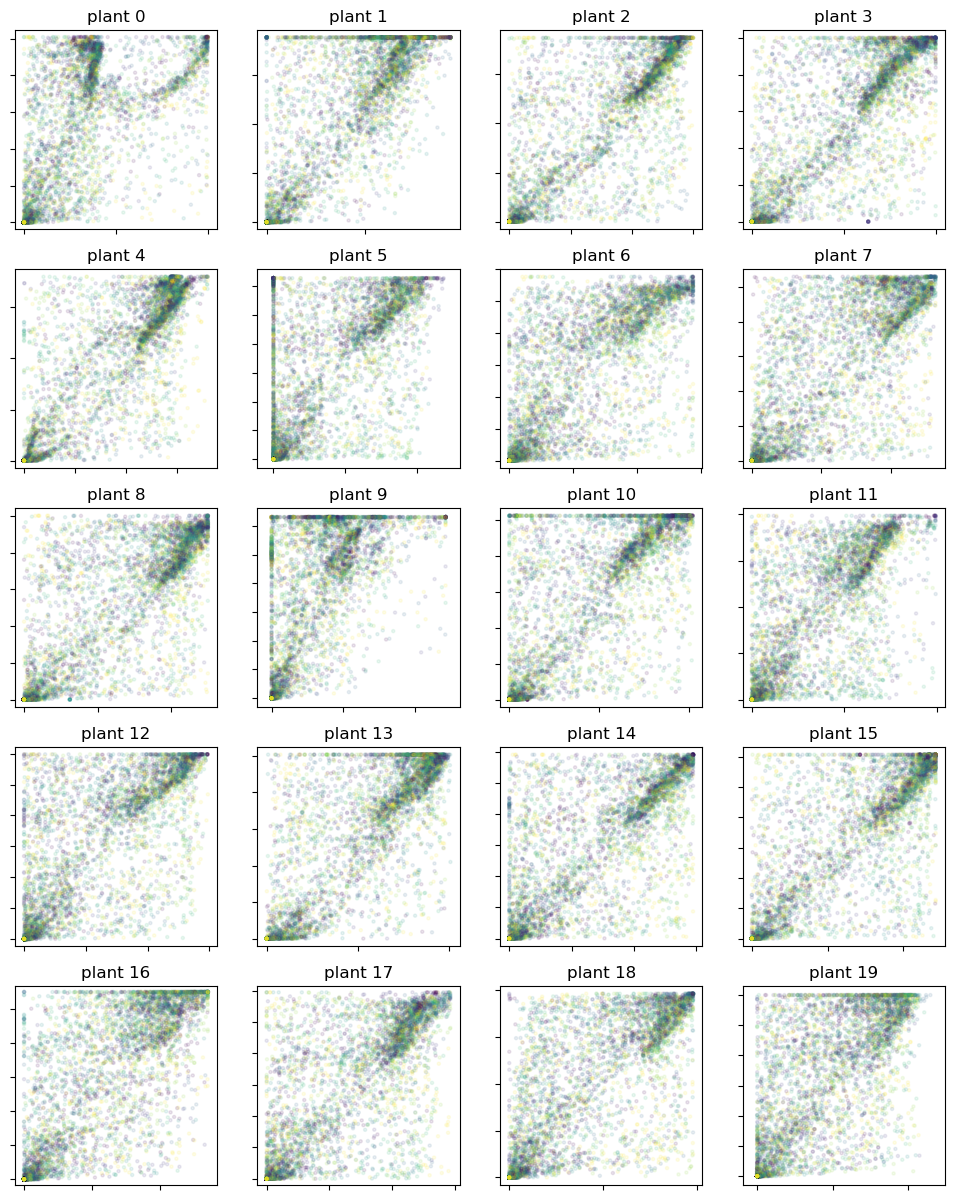

In [24]:
rows = 5
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

k = 0
for i in range (rows):
    for j in range (cols):
        if k == num_plants:
            break
        else:
            axs[i][j].scatter(power_obs_and_fcast[k]['power_obs'],
                        power_obs_and_fcast[k]['power_fcast_gfs'],
                        alpha=0.1,
                        s=5,
                        c=power_obs_and_fcast[k].index.dayofweek+1)
            axs[i][j].set_title('plant ' + str(k))
            axs[i][j].axis('equal')
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])
            k += 1

plt.show()

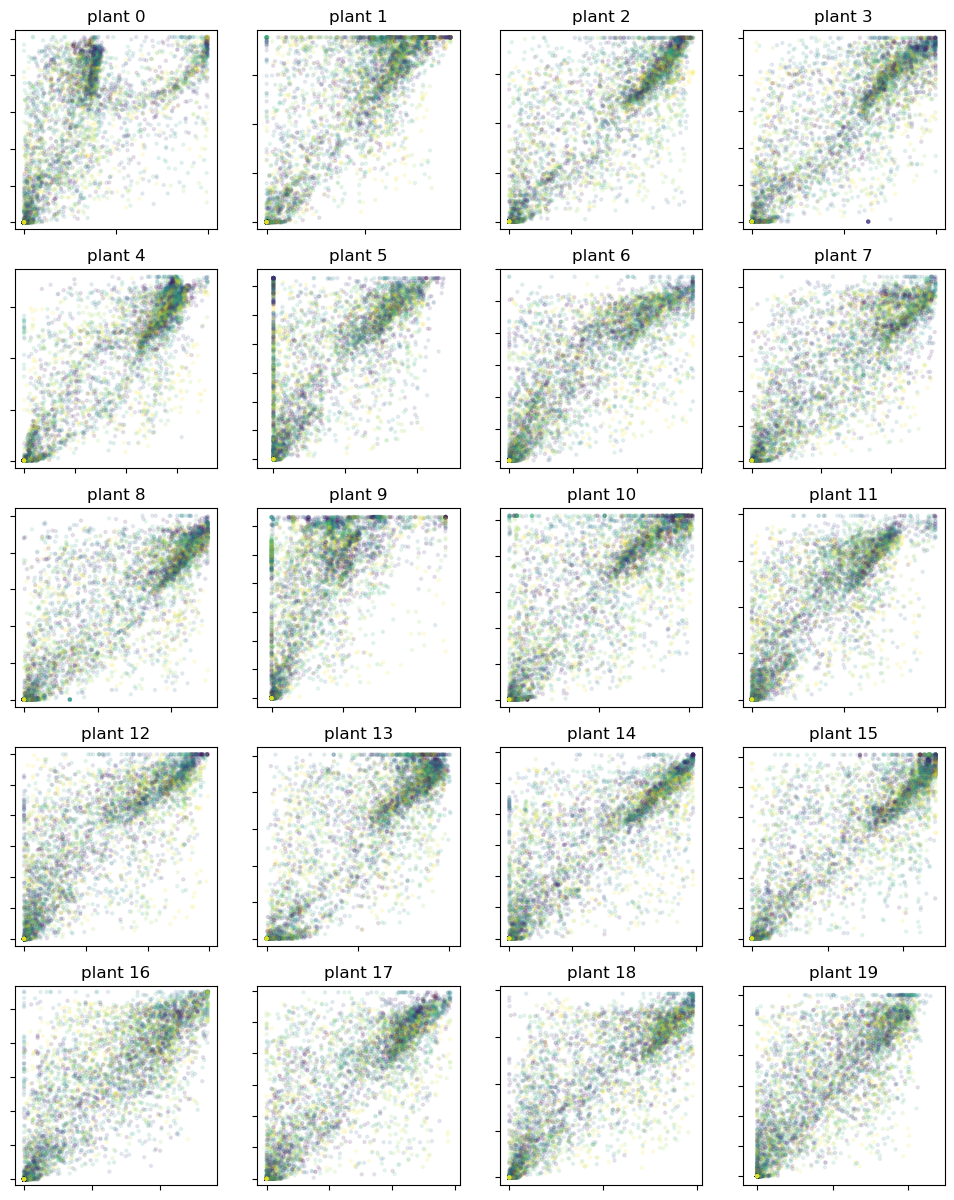

In [25]:
rows = 5
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

k = 0
for i in range (rows):
    for j in range (cols):
        if k == num_plants:
            break
        else:
            axs[i][j].scatter(power_obs_and_fcast[k]['power_obs'],
                        power_obs_and_fcast[k]['power_fcast_ifs'],
                        alpha=0.1,
                        s=5,
                        c=power_obs_and_fcast[k].index.dayofweek+1)
            axs[i][j].set_title('plant ' + str(k))
            axs[i][j].axis('equal')
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])
            k += 1

plt.show()

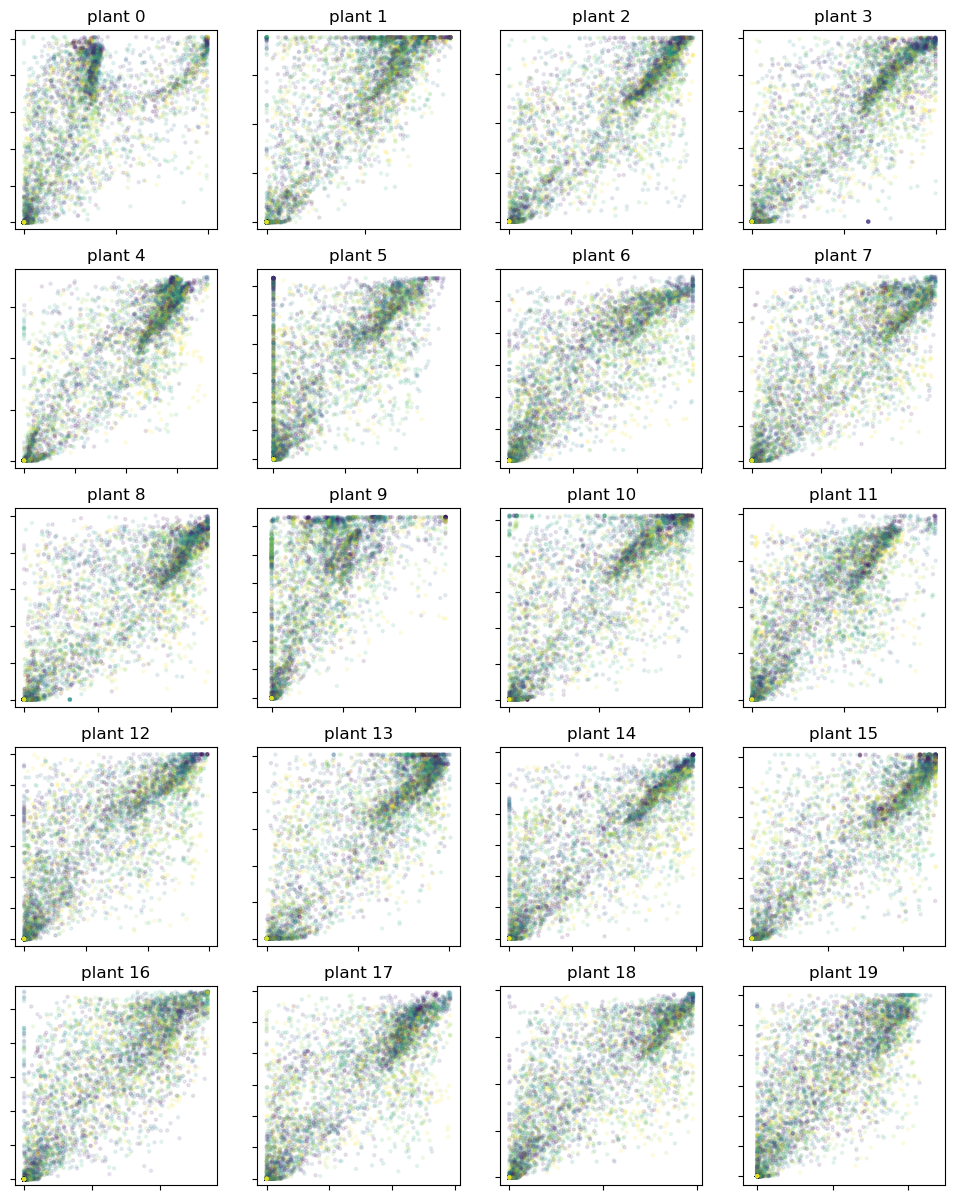

In [26]:
rows = 5
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

k = 0
for i in range (rows):
    for j in range (cols):
        if k == num_plants:
            break
        else:
            axs[i][j].scatter(power_obs_and_fcast[k]['power_obs'],
                        power_obs_and_fcast[k]['power_fcast_mean'],
                        alpha=0.1,
                        s=5,
                        c=power_obs_and_fcast[k].index.dayofweek+1)
            axs[i][j].set_title('plant ' + str(k))
            axs[i][j].axis('equal')
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])
            k += 1

plt.show()

There's still something very off about plants 0, 5, and 9. 

Let's do a few things with time:
1. Convert timezone so that power is centered on the day for correct daily totals (otherwise, sunset at the site could be after midnight UTC):
2. Add week number since our start date, which is our first init_date (`2024-03-10`) plus one day. We can get that with `power_obs_and_fcast[0].index[0].floor('1d')`. Then calculate number of days since the start date, divide by 7 days per week, and take the floor to get integer weeks since the start.
3. Calculate daily total energy

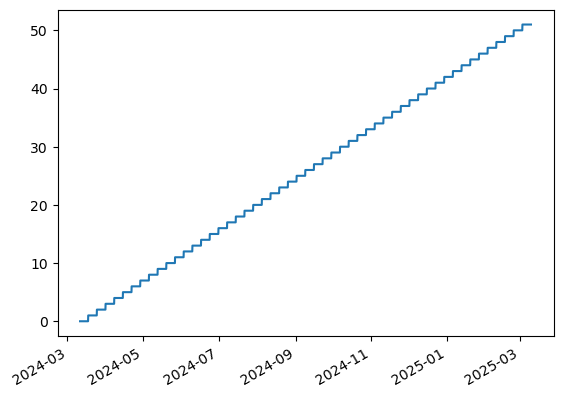

power_obs  power_fcast_gfs  power_fcast_ifs  \
2024-03-11 00:00:00-05:00    481.550       867.117922       837.657215   
2024-03-12 00:00:00-05:00    578.675       762.697937       497.658293   
2024-03-13 00:00:00-05:00    302.775       869.399369       786.147993   
2024-03-14 00:00:00-05:00    368.100       748.960185       559.964421   
2024-03-15 00:00:00-05:00    326.375      1032.079931       368.667004   

                           power_fcast_mean  week  
2024-03-11 00:00:00-05:00        852.387568   0.0  
2024-03-12 00:00:00-05:00        630.178115   0.0  
2024-03-13 00:00:00-05:00        827.773681   0.0  
2024-03-14 00:00:00-05:00        654.462303   0.0  
2024-03-15 00:00:00-05:00        700.373467   0.0

In [27]:
day_one = (power_obs_and_fcast[0].index[0].floor('1d')).tz_convert(tz='US/Central')
power_obs_and_fcast_daily = {} # empty dict for daily energy dataframes

for i in range(num_plants):
    # convert timezone
    power_obs_and_fcast[i].index =  power_obs_and_fcast[i].index.tz_convert('US/Central')
    # add week
    power_obs_and_fcast[i]['week'] = np.floor((power_obs_and_fcast[i].index - day_one).days / 7)
    # daily totals of all columns but 'week', then add week number
    power_obs_and_fcast_daily[i] = power_obs_and_fcast[i].drop('week', axis=1).resample('1D').sum()
    power_obs_and_fcast_daily[i]['week'] = power_obs_and_fcast[i]['week'].resample('1D').min()

# plot one to make sure it looks right
power_obs_and_fcast[i]['week'].plot()
plt.show()

# check one of the daily dataframes
power_obs_and_fcast_daily[i].head()

In [28]:
power_obs_and_fcast_daily[i].tail()

power_obs  power_fcast_gfs  power_fcast_ifs  \
2025-03-05 00:00:00-06:00   1008.850      1136.759579      1120.245896   
2025-03-06 00:00:00-06:00   1015.650      1131.977778      1103.444441   
2025-03-07 00:00:00-06:00    383.300       836.412197       546.246162   
2025-03-08 00:00:00-06:00    469.225      1005.515920       271.282969   
2025-03-09 00:00:00-06:00    545.400      1164.676817      1146.776917   

                           power_fcast_mean  week  
2025-03-05 00:00:00-06:00       1128.502738  51.0  
2025-03-06 00:00:00-06:00       1117.711110  51.0  
2025-03-07 00:00:00-06:00        691.329179  51.0  
2025-03-08 00:00:00-06:00        638.399444  51.0  
2025-03-09 00:00:00-06:00       1155.726867  51.0

Quick plot:

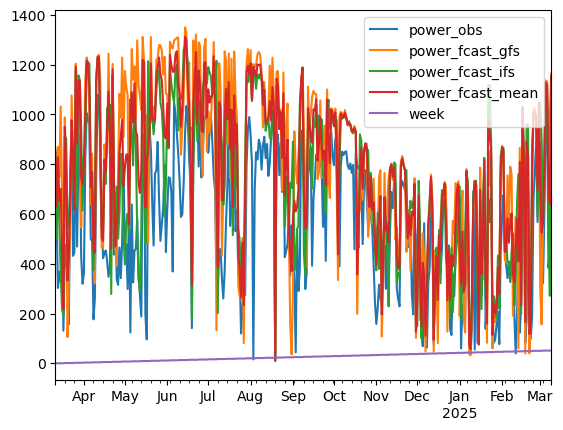

In [29]:
power_obs_and_fcast_daily[i].plot()
plt.show()

Loop through plants and then weeks, calculating:
1. weekly energy after dropping the forecast-based "outage day" (this is the amount of energy we would actually get after sticking to our scheduled outage)
2. weekly energy after dropping the day with lowest actual energy (this is what we would get with a perfect forecast)
3. weekly energy after dropping all possible random day (this is the amount of energy we would have gotten without a forecast)
4. weekly energy after subtracting the average of all days (this is what we should get from the random day, but over long periods of time)

In [30]:
num_days = 7  # number of days out to schedule. currently can be up to 7. could be shorter, e.g., 5 to just schdeule Monday-Friday

In [31]:
weekly_optimal = {}
weekly_fcast_gfs = {}
weekly_fcast_ifs = {}
weekly_fcast_mean = {}
weekly_rand = {}
weekly_rand_avg = {}
for i in range(num_plants):
    weekly_energy_optimal_list = []
    weekly_energy_fcast_gfs_list = []
    weekly_energy_fcast_ifs_list = []
    weekly_energy_fcast_mean_list = []
    weekly_energy_random_list = []
    weekly_energy_random_avg_list = []
    for week in power_obs_and_fcast_daily[i]['week'].unique():
        # dataframe filtered to plant and week of interest
        df_daily_temp = power_obs_and_fcast_daily[i][power_obs_and_fcast_daily[i]['week']==week].iloc[:num_days]
        # weekly energy with optimal outage scheduling
        drop_day_number = df_daily_temp['power_obs'].argmin()
        we_opt = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
        
        # weekly energy with forecast-based outage scheduling
        drop_day_number = df_daily_temp['power_fcast_gfs'].argmin()
        we_fcast_gfs = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
        drop_day_number = df_daily_temp['power_fcast_ifs'].argmin()
        we_fcast_ifs = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
        drop_day_number = df_daily_temp['power_fcast_mean'].argmin()
        we_fcast_mean = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()

        # weekly energy with all possible random days
        temp = []
        for j in range(num_days):
            we_rand = df_daily_temp.drop(df_daily_temp.index[j])['power_obs'].sum()
            temp.append(we_rand)
        weekly_energy_random_list.append(temp)
        weekly_energy_random_avg_list.append(np.mean(temp))

        weekly_energy_optimal_list.append(we_opt)
        weekly_energy_fcast_gfs_list.append(we_fcast_gfs)
        weekly_energy_fcast_ifs_list.append(we_fcast_ifs)
        weekly_energy_fcast_mean_list.append(we_fcast_mean)
    weekly_optimal[i] = weekly_energy_optimal_list
    weekly_fcast_gfs[i] = weekly_energy_fcast_gfs_list
    weekly_fcast_ifs[i] = weekly_energy_fcast_ifs_list
    weekly_fcast_mean[i] = weekly_energy_fcast_mean_list
    weekly_rand[i] = weekly_energy_random_list
    weekly_rand_avg[i]= weekly_energy_random_avg_list

Plot for a single plant:

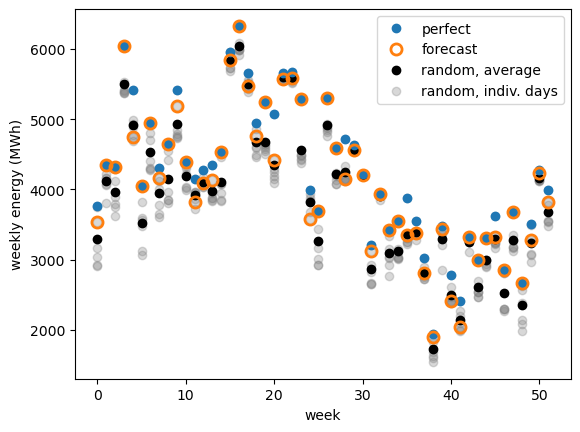

In [32]:
i = 3
# plot random first so it's in the back
plt.plot(weekly_rand[i],'o',ls='None', alpha=0.3, color='gray', label='random, indiv. days')
plt.plot(weekly_rand_avg[i],'o',ls='None', color='k', label='random, average')
plt.plot(weekly_optimal[i],'o',ls='None', label = 'perfect')
plt.plot(weekly_fcast_gfs[i],'o',ms=8,fillstyle='none',markeredgewidth=2,ls='None', label = 'forecast')

plt.ylabel('weekly energy (MWh)')
plt.xlabel('week')

# custom order for legend, since random was plotted first
handles,labels = plt.gca().get_legend_handles_labels()
handles = [handles[-2], handles[-1], handles[-3], handles[0]]
labels = [labels[-2], labels[-1], labels[-3], labels[0]]
plt.legend(handles,labels)
plt.savefig('images/weekly_energy_selection.png', dpi=400, bbox_inches='tight')
plt.show()

Calculate totals:

In [33]:
E_opt = np.sum(weekly_optimal[i])
E_fcast = np.sum(weekly_fcast_mean[i])
E_r_mean = np.mean(np.sum(weekly_rand[i], axis=0))
E_r_max = np.max(np.sum(weekly_rand[i], axis=0))
E_r_min = np.min(np.sum(weekly_rand[i], axis=0))

print('Total MWh with...')
print('perfect scheduling:  ', E_opt)
print('forecast scheduling: ', E_fcast)
print('random scheduling:   ', E_r_mean, ' (mean)')
print('random scheduling:   ', E_r_max, ' (best)')
print('random scheduling:   ', E_r_min, ' (worst)')

Total MWh with...
perfect scheduling:   219354.0
forecast scheduling:  212935.1
random scheduling:    202853.39999999997  (mean)
random scheduling:    205445.40000000002  (best)
random scheduling:    201206.28333333327  (worst)


And some relative differences:

In [34]:
print((E_opt - E_fcast)/E_opt)
print((E_opt - E_r_mean)/E_opt)

0.02926274423990442
0.07522361114910162


Loss reduction from the forecast vs random scheduling:

In [35]:
loss_fcast = (E_opt - E_fcast)/E_opt
loss_rand = (E_opt - E_r_mean)/E_opt

rel_loss_reduction = 1-loss_fcast/loss_rand

print(rel_loss_reduction)

0.6109899033974534


Bar chart:

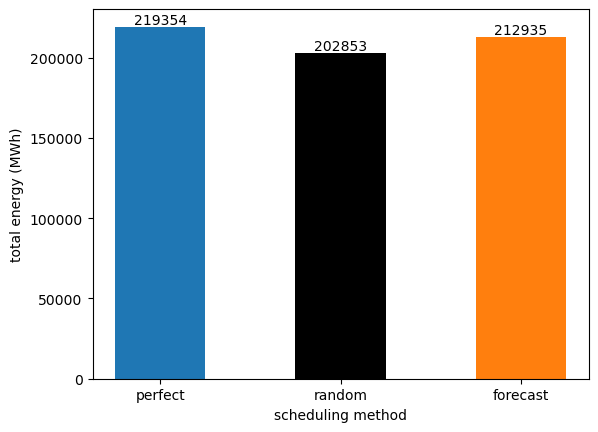

In [36]:
fig, ax = plt.subplots()
p = ax.bar(
    ['perfect', 'random', 'forecast'],
    [E_opt, E_r_mean, E_fcast],
    color = ['tab:blue','black','tab:orange'], width=0.5)
ax.bar_label(p, label_type='edge')
plt.ylabel('total energy (MWh)')
plt.xlabel('scheduling method')
plt.savefig('images/total_energy_bar.png', dpi=400, bbox_inches='tight')
plt.show()

Now, let's loop through all the plants and types of forecasts (GFS, IFS, and the average power from the two).

In [37]:
# intialize lists of dictionaries
rel_loss_reductions_gfs = [{} for i in range(num_plants)]
rel_loss_reductions_ifs = [{} for i in range(num_plants)]
rel_loss_reductions_mean = [{} for i in range(num_plants)]

# loop through scheduling horizons, 2 to 7 days out (one day doesn't give an option...)
for num_days in range(2,7+1):
    # initialize dictionaries
    weekly_optimal = {}
    weekly_fcast_gfs = {}
    weekly_fcast_ifs = {}
    weekly_fcast_mean = {}
    weekly_rand = {}
    weekly_rand_avg = {}
    for i in range(num_plants):
        # initialize lists
        weekly_energy_optimal_list = []
        weekly_energy_fcast_gfs_list = []
        weekly_energy_fcast_ifs_list = []
        weekly_energy_fcast_mean_list = []
        weekly_energy_random_list = []
        weekly_energy_random_avg_list = []
        for week in power_obs_and_fcast_daily[i]['week'].unique():
            # dataframe filtered to plant and week of interest
            df_daily_temp = power_obs_and_fcast_daily[i][power_obs_and_fcast_daily[i]['week']==week].iloc[:num_days]
            # weekly energy with optimal outage scheduling
            drop_day_number = df_daily_temp['power_obs'].argmin()
            we_opt = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
            
            # weekly energy with forecast-based outage scheduling
            drop_day_number = df_daily_temp['power_fcast_gfs'].argmin()
            we_fcast_gfs = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
            drop_day_number = df_daily_temp['power_fcast_ifs'].argmin()
            we_fcast_ifs = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
            drop_day_number = df_daily_temp['power_fcast_mean'].argmin()
            we_fcast_mean = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()

            # weekly energy with all possible random days
            temp = []
            for j in range(num_days):
                we_rand = df_daily_temp.drop(df_daily_temp.index[j])['power_obs'].sum()
                temp.append(we_rand)
            weekly_energy_random_list.append(temp)
            weekly_energy_random_avg_list.append(np.mean(temp))

            weekly_energy_optimal_list.append(we_opt)
            weekly_energy_fcast_gfs_list.append(we_fcast_gfs)
            weekly_energy_fcast_ifs_list.append(we_fcast_ifs)
            weekly_energy_fcast_mean_list.append(we_fcast_mean)
        weekly_optimal[i] = weekly_energy_optimal_list
        weekly_fcast_gfs[i] = weekly_energy_fcast_gfs_list
        weekly_fcast_ifs[i] = weekly_energy_fcast_ifs_list
        weekly_fcast_mean[i] = weekly_energy_fcast_mean_list
        weekly_rand[i] = weekly_energy_random_list
        weekly_rand_avg[i]= weekly_energy_random_avg_list

        E_opt = np.sum(weekly_optimal[i])
        E_fcast_gfs = np.sum(weekly_fcast_gfs[i])
        E_fcast_ifs = np.sum(weekly_fcast_ifs[i])
        E_fcast_mean = np.sum(weekly_fcast_mean[i])
        E_r_mean = np.mean(np.sum(weekly_rand[i], axis=0))
        E_r_max = np.max(np.sum(weekly_rand[i], axis=0))
        E_r_min = np.min(np.sum(weekly_rand[i], axis=0))

        loss_fcast_gfs = (E_opt - E_fcast_gfs)/E_opt
        loss_fcast_ifs = (E_opt - E_fcast_ifs)/E_opt
        loss_fcast_mean = (E_opt - E_fcast_mean)/E_opt
        loss_rand = (E_opt - E_r_mean)/E_opt

        rel_loss_reduction_gfs = 1-loss_fcast_gfs/loss_rand
        rel_loss_reductions_gfs[i][num_days] = rel_loss_reduction_gfs

        rel_loss_reduction_ifs = 1-loss_fcast_ifs/loss_rand
        rel_loss_reductions_ifs[i][num_days] = rel_loss_reduction_ifs

        rel_loss_reduction_mean = 1-loss_fcast_mean/loss_rand
        rel_loss_reductions_mean[i][num_days] = rel_loss_reduction_mean

We can convert the list of dictionaries into a dataframe with plants as columns and days-ahead as rows:

In [38]:
df_summary_gfs = pd.DataFrame(rel_loss_reductions_gfs).T
df_summary_ifs = pd.DataFrame(rel_loss_reductions_ifs).T
df_summary_mean = pd.DataFrame(rel_loss_reductions_mean).T
df_summary_gfs

0         1         2         3         4         5         6   \
2  0.720982  0.562602  0.812013  0.272412  0.743743  0.766786  0.732410   
3  0.706760  0.550409  0.597152  0.473086  0.833692  0.701156  0.772003   
4  0.675662  0.619246  0.656580  0.556610  0.773901  0.485929  0.605643   
5  0.591108  0.659063  0.585385  0.518968  0.663376  0.525254  0.529101   
6  0.644024  0.545255  0.671788  0.627847  0.657382  0.528298  0.492760   
7  0.625739  0.516562  0.670838  0.579946  0.653522  0.530922  0.401864   

         7         8         9         10        11        12        13  \
2  0.699306  0.446771  0.397683  0.670874  0.678750  0.496234  0.609543   
3  0.640021  0.554496  0.515689  0.669344  0.659571  0.586295  0.608309   
4  0.570645  0.527251  0.503229  0.559078  0.556222  0.632072  0.507317   
5  0.557126  0.684773  0.317311  0.517926  0.421587  0.508237  0.591488   
6  0.549996  0.636872  0.465739  0.592854  0.508259  0.499343  0.679163   
7  0.423266  0.636952  0.561648  0.543753  0.387837  0.485493  0.580379   

         14        15        16        17        18        19  
2  0.632055  0.825823  0.411062  0.829491  0.642042  0.729096  
3  0.693287  0.757796  0.512434  0.802563  0.650850  0.467158  
4  0.663775  0.746949  0.419431  0.714568  0.596591  0.484441  
5  0.597404  0.717176  0.545655  0.706514  0.617918  0.493595  
6  0.573722  0.733272  0.561445  0.663968  0.477917  0.407645  
7  0.505289  0.687090  0.629088  0.663032  0.456503  0.480377

Now, let's drop plants 0, 5 and 9:

In [39]:
df_summary_gfs = df_summary_gfs.drop([0, 5, 9], axis=1)
df_summary_ifs = df_summary_ifs.drop([0, 5, 9], axis=1)
df_summary_mean = df_summary_mean.drop([0, 5, 9], axis=1)
agg_specs_orig_df_dropped = agg_specs_orig_df.drop([0, 5, 9], axis=1)
df_summary_gfs

1         2         3         4         6         7         8   \
2  0.562602  0.812013  0.272412  0.743743  0.732410  0.699306  0.446771   
3  0.550409  0.597152  0.473086  0.833692  0.772003  0.640021  0.554496   
4  0.619246  0.656580  0.556610  0.773901  0.605643  0.570645  0.527251   
5  0.659063  0.585385  0.518968  0.663376  0.529101  0.557126  0.684773   
6  0.545255  0.671788  0.627847  0.657382  0.492760  0.549996  0.636872   
7  0.516562  0.670838  0.579946  0.653522  0.401864  0.423266  0.636952   

         10        11        12        13        14        15        16  \
2  0.670874  0.678750  0.496234  0.609543  0.632055  0.825823  0.411062   
3  0.669344  0.659571  0.586295  0.608309  0.693287  0.757796  0.512434   
4  0.559078  0.556222  0.632072  0.507317  0.663775  0.746949  0.419431   
5  0.517926  0.421587  0.508237  0.591488  0.597404  0.717176  0.545655   
6  0.592854  0.508259  0.499343  0.679163  0.573722  0.733272  0.561445   
7  0.543753  0.387837  0.485493  0.580379  0.505289  0.687090  0.629088   

         17        18        19  
2  0.829491  0.642042  0.729096  
3  0.802563  0.650850  0.467158  
4  0.714568  0.596591  0.484441  
5  0.706514  0.617918  0.493595  
6  0.663968  0.477917  0.407645  
7  0.663032  0.456503  0.480377

And calculate the median across plants for each day-ahead:

In [40]:
df_summary_gfs.mean(axis=1)

2    0.634955
3    0.636969
4    0.599431
5    0.583253
6    0.581146
7    0.547164
dtype: float64

And a plot:

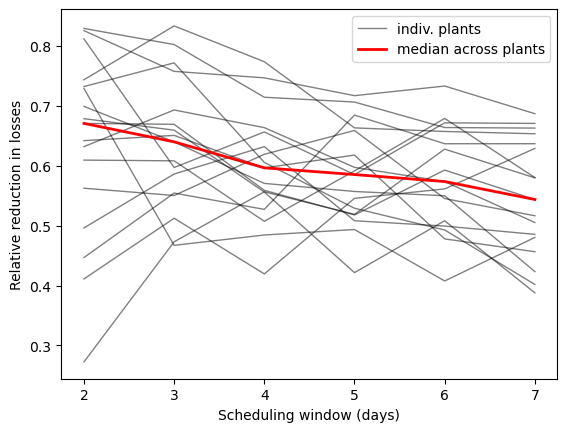

In [41]:
df_summary_gfs.plot(color='black', linewidth=1, alpha=0.5, legend=False)
df_summary_gfs.median(axis=1).plot(color='red', linewidth=2, label='median across plants')
plt.ylabel('Relative reduction in losses')
plt.xlabel('Scheduling window (days)')

# custom legend
handles,labels = plt.gca().get_legend_handles_labels()
handles = [handles[-2], handles[-1]]
labels = ['indiv. plants', labels[-1]]
plt.legend(handles,labels)

# plt.legend()
plt.show()

In [42]:
df_summary_ifs

1         2         3         4         6         7         8   \
2  0.685008  0.933596  0.605115  0.721833  0.744357  0.746198  0.771510   
3  0.692488  0.834962  0.636973  0.690348  0.766026  0.724683  0.836817   
4  0.688702  0.781931  0.693579  0.652307  0.670722  0.651074  0.769681   
5  0.619560  0.729746  0.708261  0.658887  0.639511  0.625222  0.775260   
6  0.553423  0.682383  0.706990  0.667446  0.533777  0.623576  0.728706   
7  0.543562  0.648850  0.575207  0.540351  0.516230  0.582747  0.666995   

         10        11        12        13        14        15        16  \
2  0.761194  0.854931  0.801053  0.846991  0.905238  0.783846  0.540195   
3  0.669307  0.743312  0.743938  0.646454  0.823609  0.699423  0.654408   
4  0.587731  0.735201  0.738846  0.767646  0.689903  0.722278  0.637778   
5  0.596306  0.724499  0.750003  0.770684  0.693063  0.693288  0.669978   
6  0.566240  0.738530  0.695663  0.760448  0.621116  0.639379  0.593110   
7  0.476083  0.701882  0.577968  0.666728  0.562607  0.609664  0.609912   

         17        18        19  
2  0.896431  0.790812  0.601911  
3  0.831021  0.718366  0.691299  
4  0.679839  0.744045  0.603072  
5  0.609389  0.749021  0.591953  
6  0.605238  0.681375  0.584277  
7  0.673357  0.654366  0.522418

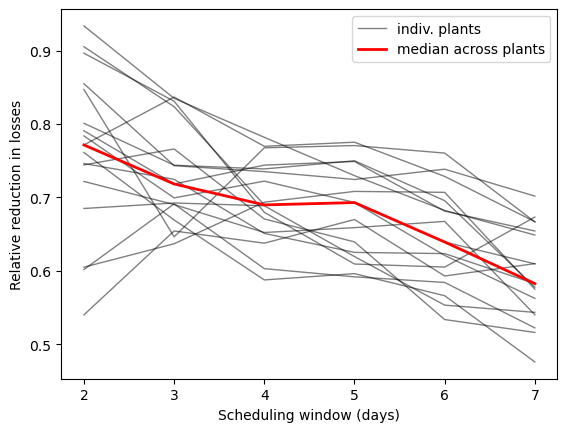

In [43]:
df_summary_ifs.plot(color='black', linewidth=1, alpha=0.5, legend=False)
df_summary_ifs.median(axis=1).plot(color='red', linewidth=2, label='median across plants')
plt.ylabel('Relative reduction in losses')
plt.xlabel('Scheduling window (days)')

# custom legend
handles,labels = plt.gca().get_legend_handles_labels()
handles = [handles[-2], handles[-1]]
labels = ['indiv. plants', labels[-1]]
plt.legend(handles,labels)

# plt.legend()
plt.show()

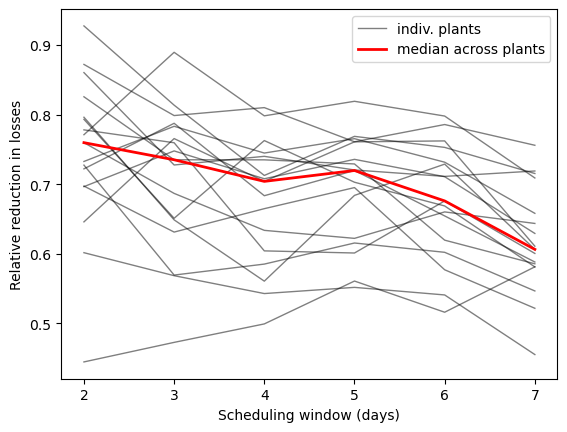

In [44]:
df_summary_mean.plot(color='black', linewidth=1, alpha=0.5, legend=False)
df_summary_mean.median(axis=1).plot(color='red', linewidth=2, label='median across plants')
plt.ylabel('Relative reduction in losses')
plt.xlabel('Scheduling window (days)')

# custom legend
handles,labels = plt.gca().get_legend_handles_labels()
handles = [handles[-2], handles[-1]]
labels = ['indiv. plants', labels[-1]]
plt.legend(handles,labels)

# plt.legend()
plt.show()

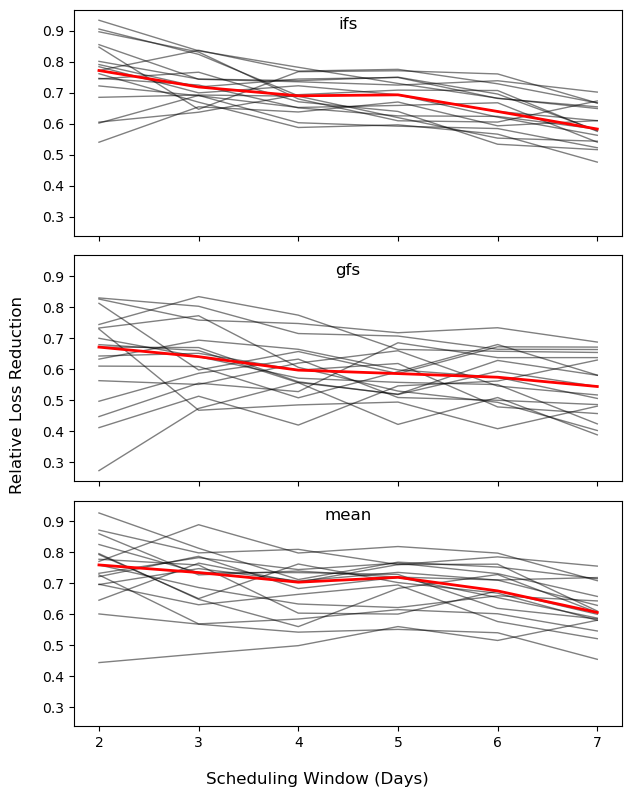

In [45]:
# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(6.4, 8))
# fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
# fig.suptitle('Sharing x per column, y per row')
ax1.set_title('ifs', y=1, pad=-14)
ax1.plot(df_summary_ifs.index, df_summary_ifs, color='black', linewidth=1, alpha=0.5,)
ax1.plot(df_summary_ifs.index, df_summary_ifs.median(axis=1), color='red', linewidth=2)
ax2.set_title('gfs', y=1, pad=-14)
ax2.plot(df_summary_gfs.index, df_summary_gfs, color='black', linewidth=1, alpha=0.5,)
ax2.plot(df_summary_gfs.index, df_summary_gfs.median(axis=1), color='red', linewidth=2)
ax3.set_title('mean', y=1, pad=-14)
ax3.plot(df_summary_mean.index, df_summary_mean, color='black', linewidth=1, alpha=0.5,)
ax3.plot(df_summary_mean.index, df_summary_mean.median(axis=1), color='red', linewidth=2)

for ax in fig.get_axes():
    ax.label_outer()

fig.supxlabel('Scheduling Window (Days)')
fig.supylabel('Relative Loss Reduction')
fig.tight_layout()
plt.savefig('images/sched_window_reduction_plant-level.png', dpi=400, bbox_inches='tight')

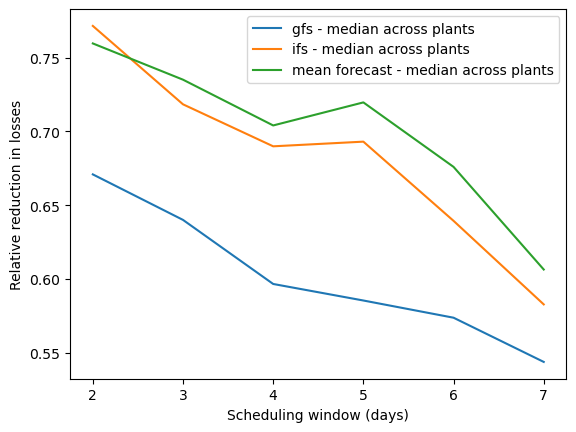

In [46]:
df_summary_gfs.median(axis=1).plot(label='gfs - median across plants')
df_summary_ifs.median(axis=1).plot(label='ifs - median across plants')
df_summary_mean.median(axis=1).plot(label='mean forecast - median across plants')
plt.legend()
plt.ylabel('Relative reduction in losses')
plt.xlabel('Scheduling window (days)')
plt.savefig('images/sched_window_reduction.png', dpi=400, bbox_inches='tight')
plt.show()

In [47]:
# import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature

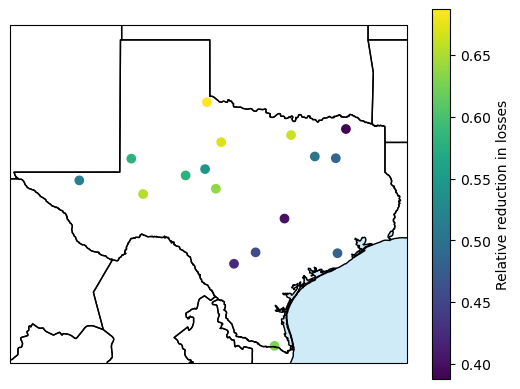

In [48]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-106.8, -93.3, 25.5, 37],
              crs=crs.PlateCarree()) ## Important

plt.scatter(agg_specs_orig_df_dropped.T['longitude'], agg_specs_orig_df_dropped.T['latitude'], c=df_summary_gfs.T[7].values)
plt.colorbar(label='Relative reduction in losses')
plt.show()

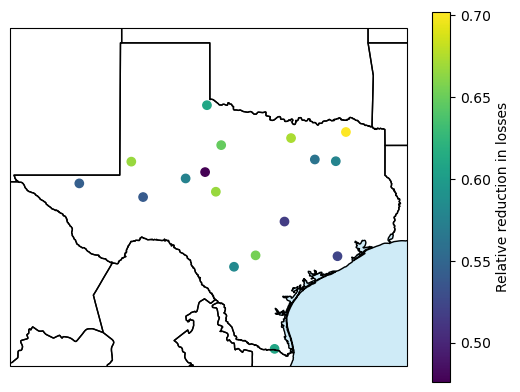

In [49]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-106.8, -93.3, 25.5, 37],
              crs=crs.PlateCarree()) ## Important

plt.scatter(agg_specs_orig_df_dropped.T['longitude'], agg_specs_orig_df_dropped.T['latitude'], c=df_summary_ifs.T[7].values)
plt.colorbar(label='Relative reduction in losses')
plt.show()

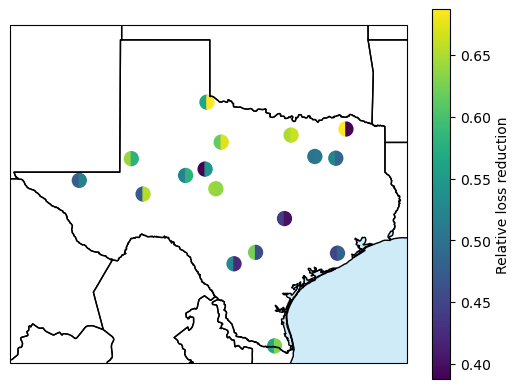

In [50]:
from matplotlib.markers import MarkerStyle
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-106.8, -93.3, 25.5, 37],
              crs=crs.PlateCarree()) ## Important

plt.scatter(agg_specs_orig_df_dropped.T['longitude'],
            agg_specs_orig_df_dropped.T['latitude'],
            s=100,
            c=df_summary_ifs.T[7].values,
            marker=MarkerStyle("o", fillstyle="left"))
plt.scatter(agg_specs_orig_df_dropped.T['longitude'],
            agg_specs_orig_df_dropped.T['latitude'],
            s=100,
            c=df_summary_gfs.T[7].values,
            marker=MarkerStyle("o", fillstyle="right"))
plt.colorbar(label='Relative loss reduction')
plt.savefig('images/rlr_map_gfs_ifs.png', dpi=400, bbox_inches='tight')
plt.show()


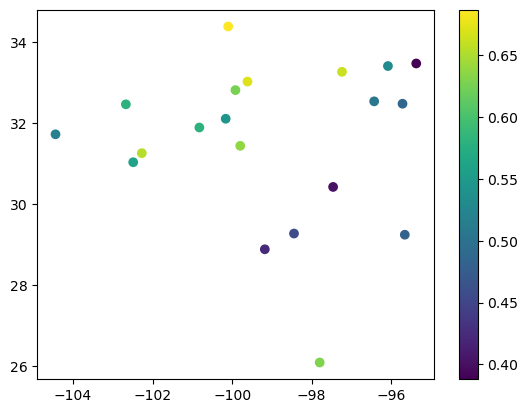

In [51]:
plt.scatter(agg_specs_orig_df.T['longitude'], agg_specs_orig_df.T['latitude'], c=pd.DataFrame(rel_loss_reductions_gfs)[7].values)
plt.colorbar()
plt.show()